## Modules

In [1]:
import numpy as np
import pandas as pd; pd.set_option("display.max_colwidth", 1000)

from GridPythonModule import *
from GPM_wrapper import *

#from tqdm.notebook import tqdm
# ----- Debugger -----
# from IPython.core.debugger import Pdb; Pdb().set_trace()

## Scratch

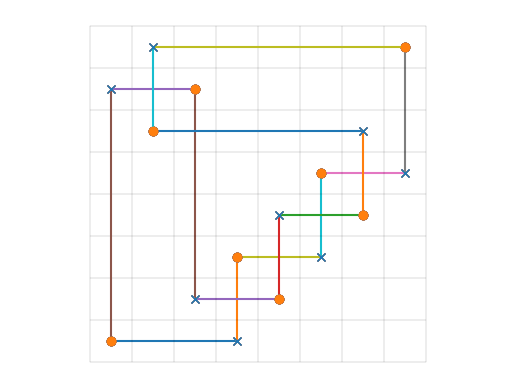

[[2, 0, 3, 11], [10, 4, 11, 3], [4, 10, 5, 9], [8, 6, 9, 5], [6, 1, 7, 2], [0, 7, 1, 8]]


In [2]:
mg = Grid(*[[3, 2, 5, 4, 7, 6, 0, 1], [0, 4, 3, 6, 5, 1, 2, 7]]); mg.draw()
print(reduce(mg.get_PD()))

In [ ]:
nontrivknot = None
while nontrivknot is None:
    G = generate_random_grid(20)
    sG = set(sum(simplify_grid(G), []))
    if number_of_components(G) == 1 and sG != {0,1}:
        nontrivknot = G
#---
mg = Grid(*G); mg.draw()
PD = mg.get_PD()
print(reduce(PD))
#---
mgs = Grid(*simplify_grid(G)); mgs.draw()
PDs = mgs.get_PD()
print(reduce(PDs))

# Validation on outputs of pd_to_hfk and my code to get PD notation

## Preparing DataFrames for input and output

### Input DataFrame `knotinfo_df` (from KnotInfo)

In [4]:
knotinfo_df = pd.read_csv("./data/knotinfo_3-8.csv").set_index('Name')
display(knotinfo_df)

,Alternating,Fibered,PD Notation,Genus-3D,Ozsvath-Szabo tau,L-space,Nu,Epsilon,HFK Polyomial
Name,,,,,,,,,
3_1,Y,Y,[[1;5;2;4];[3;1;4;6];[5;3;6;2]],1,1,Yes,{1;-1},1,1a^(-1)m^(-2)+ 1a^(0)m^(-1)+ 1a^(1)m^(0)
4_1,Y,Y,[[4;2;5;1];[8;6;1;5];[6;3;7;4];[2;7;3;8]],1,0,No,{0;0},0,1a^(-1)m^(-1)+ 3a^(0)m^(0)+ 1a^(1)m^(1)
5_1,Y,Y,[[2;8;3;7];[4;10;5;9];[6;2;7;1];[8;4;9;3];[10;6;1;5]],2,2,Yes,{2;-2},1,1a^(-2)m^(-4)+ 1a^(-1)m^(-3)+ 1a^(0)m^(-2)+ 1a^(1)m^(-1)+ 1a^(2)m^(0)
5_2,Y,N,[[1;5;2;4];[3;9;4;8];[5;1;6;10];[7;3;8;2];[9;7;10;6]],1,1,No,{1;-1},1,2a^(-1)m^(-2)+ 3a^(0)m^(-1)+ 2a^(1)m^(0)
6_1,Y,N,[[1;7;2;6];[3;10;4;11];[5;3;6;2];[7;1;8;12];[9;4;10;5];[11;9;12;8]],1,0,No,{0;0},0,2a^(-1)m^(-1)+ 5a^(0)m^(0)+ 2a^(1)m^(1)
6_2,Y,Y,[[1;8;2;9];[3;11;4;10];[5;1;6;12];[7;2;8;3];[9;7;10;6];[11;5;12;4]],2,1,No,{1;-1},1,1a^(-2)m^(-3)+ 3a^(-1)m^(-2)+ 3a^(0)m^(-1)+ 3a^(1)m^(0)+ 1a^(2)m^(1)
6_3,Y,Y,[[4;2;5;1];[8;4;9;3];[12;9;1;10];[10;5;11;6];[6;11;7;12];[2;8;3;7]],2,0,No,{0;0},0,1a^(-2)m^(-2)+ 3a^(-1)m^(-1)+ 5a^(0)m^(0)+ 3a^(1)m^(1)+ 1a^(2)m^(2)
7_1,Y,Y,[[1;9;2;8];[3;11;4;10];[5;13;6;12];[7;1;8;14];[9;3;10;2];[11;5;12;4];[13;7;14;6]],3,3,Yes,{3;-3},1,1a^(-3)m^(-6)+ 1a^(-2)m^(-5)+ 1a^(-1)m^(-4)+ 1a^(0)m^(-3)+ 1a^(1)m^(-2)+ 1a^(2)m^(-1)+ 1a^(3)m^(0)
7_2,Y,N,[[2;10;3;9];[4;14;5;13];[6;12;7;11];[8;2;9;1];[10;8;11;7];[12;6;13;5];[14;4;1;3]],1,1,No,{1;-1},1,3a^(-1)m^(-2)+ 5a^(0)m^(-1)+ 3a^(1)m^(0)


### Output DataFrame `hfk_df` (generated by pd_to_hfk from PD notations given from grid diagrams)

In [3]:
from knot_floer_homology import *

list_of_knots = ['3_1', '4_1', '5_1', '5_2', '6_1', '6_2', '6_3', '7_1', '7_2', '7_3', '7_4', '7_5', '7_6', '7_7', '8_1', '8_2', '8_3', '8_4', '8_5', '8_6', '8_7', '8_8', '8_9', '8_10', '8_11', '8_12', '8_13', '8_14', '8_15', '8_16', '8_17', '8_18', '8_19', '8_20', '8_21']

def replace_to_hfk(knot_name):
    G = load_knot(knot_name); #draw_grid(G)
    PD = Grid(*G).get_PD(); #print(PD)
    hfk = pd_to_hfk(PD); #print(hfk)
    hfk['Name'] = knot_name
    hfk['PD Notation'] = PD
    hfk['Grid'] = G
    return hfk

hfk_list = list(map(replace_to_hfk, list_of_knots))
hfk_df = pd.DataFrame(hfk_list).set_index('Name'); display(hfk_df)

,L_space_knot,epsilon,fibered,modulus,nu,ranks,seifert_genus,tau,total_rank,PD Notation,Grid
Name,,,,,,,,,,,
3_1,True,-1,True,2,0,"{(-1, 0): 1, (0, 1): 1, (1, 2): 1}",1,-1,3,"[[3, 0, 4, 1], [1, 4, 2, 5], [5, 2, 0, 3]]","[[4, 0, 1, 2, 3], [1, 2, 3, 4, 0]]"
4_1,False,0,True,2,0,"{(-1, -1): 1, (0, 0): 3, (1, 1): 1}",1,0,5,"[[3, 0, 4, 1], [9, 4, 0, 5], [6, 2, 7, 1], [5, 8, 6, 9], [2, 8, 3, 7]]","[[5, 0, 3, 4, 2, 1], [2, 4, 5, 1, 0, 3]]"
5_1,True,-1,True,2,-1,"{(-2, 0): 1, (-1, 1): 1, (0, 2): 1, (1, 3): 1, (2, 4): 1}",2,-2,5,"[[8, 15, 9, 0], [1, 14, 2, 15], [0, 7, 1, 8], [12, 9, 13, 10], [13, 2, 14, 3], [5, 10, 6, 11], [6, 3, 7, 4], [11, 4, 12, 5]]","[[4, 5, 6, 0, 1, 2, 3], [6, 2, 3, 4, 5, 0, 1]]"
5_2,False,-1,False,2,0,"{(-1, 0): 2, (0, 1): 3, (1, 2): 2}",1,-1,7,"[[6, 9, 7, 0], [0, 5, 1, 6], [4, 1, 5, 2], [8, 3, 9, 4], [2, 7, 3, 8]]","[[1, 5, 6, 2, 3, 4, 0], [6, 0, 4, 5, 1, 2, 3]]"
6_1,False,0,False,2,0,"{(-1, -1): 2, (0, 0): 5, (1, 1): 2}",1,0,9,"[[3, 0, 4, 1], [13, 4, 0, 5], [5, 12, 6, 13], [11, 6, 12, 7], [8, 2, 9, 1], [7, 10, 8, 11], [2, 10, 3, 9]]","[[7, 0, 5, 6, 3, 4, 2, 1], [2, 6, 7, 4, 5, 1, 0, 3]]"
6_2,False,-1,True,2,0,"{(-2, -1): 1, (-1, 0): 3, (0, 1): 3, (1, 2): 3, (2, 3): 1}",2,-1,11,"[[7, 0, 8, 1], [16, 1, 17, 2], [17, 8, 0, 9], [3, 6, 4, 7], [2, 15, 3, 16], [9, 14, 10, 15], [12, 6, 13, 5], [13, 10, 14, 11], [4, 12, 5, 11]]","[[7, 2, 4, 5, 6, 1, 0, 3], [5, 6, 7, 0, 3, 4, 2, 1]]"
6_3,False,0,True,2,0,"{(-2, -2): 1, (-1, -1): 3, (0, 0): 5, (1, 1): 3, (2, 2): 1}",2,0,13,"[[7, 0, 8, 1], [1, 8, 2, 9], [13, 2, 0, 3], [4, 10, 5, 9], [3, 12, 4, 13], [10, 6, 11, 5], [6, 12, 7, 11]]","[[7, 0, 3, 5, 6, 4, 2, 1], [3, 4, 6, 7, 2, 1, 0, 5]]"
7_1,True,-1,True,2,-2,"{(-3, 0): 1, (-2, 1): 1, (-1, 2): 1, (0, 3): 1, (1, 4): 1, (2, 5): 1, (3, 6): 1}",3,-3,7,"[[10, 19, 11, 0], [18, 9, 19, 10], [1, 8, 2, 9], [0, 17, 1, 18], [11, 2, 12, 3], [6, 3, 7, 4], [7, 12, 8, 13], [15, 4, 16, 5], [16, 13, 17, 14], [5, 14, 6, 15]]","[[1, 6, 7, 8, 0, 2, 3, 4, 5], [8, 0, 1, 4, 5, 6, 7, 2, 3]]"
7_2,False,-1,False,2,0,"{(-1, 0): 3, (0, 1): 5, (1, 2): 3}",1,-1,11,"[[10, 13, 11, 0], [0, 9, 1, 10], [8, 1, 9, 2], [2, 7, 3, 8], [6, 3, 7, 4], [12, 5, 13, 6], [4, 11, 5, 12]]","[[1, 7, 8, 5, 6, 2, 3, 4, 0], [8, 0, 6, 7, 4, 5, 1, 2, 3]]"


## Validation

In [16]:
for name, ranks in hfk_df['ranks'].items():
    print(f"{name}: {[list(ranks.keys())[i] for i in (0,-1)]}")

3_1: [(-1, 0), (1, 2)]
4_1: [(-1, -1), (1, 1)]
5_1: [(-2, 0), (2, 4)]
5_2: [(-1, 0), (1, 2)]
6_1: [(-1, -1), (1, 1)]
6_2: [(-2, -1), (2, 3)]
6_3: [(-2, -2), (2, 2)]
7_1: [(-3, 0), (3, 6)]
7_2: [(-1, 0), (1, 2)]
7_3: [(-2, -4), (2, 0)]
7_4: [(-1, -2), (1, 0)]
7_5: [(-2, 0), (2, 4)]
7_6: [(-2, -1), (2, 3)]
7_7: [(-2, -2), (2, 2)]
8_1: [(-1, -1), (1, 1)]
8_2: [(-3, -1), (3, 5)]
8_3: [(-1, -1), (1, 1)]
8_4: [(-2, -1), (2, 3)]
8_5: [(-3, -5), (3, 1)]
8_6: [(-2, -1), (2, 3)]
8_7: [(-3, -4), (3, 2)]
8_8: [(-2, -2), (2, 2)]
8_9: [(-3, -3), (3, 3)]
8_10: [(-3, -4), (3, 2)]
8_11: [(-2, -1), (2, 3)]
8_12: [(-2, -2), (2, 2)]
8_13: [(-2, -2), (2, 2)]
8_14: [(-2, -1), (2, 3)]
8_15: [(-2, 0), (2, 4)]
8_16: [(-3, -2), (3, 4)]
8_17: [(-3, -3), (3, 3)]
8_18: [(-3, -3), (3, 3)]
8_19: [(-3, -6), (3, 0)]
8_20: [(-2, -2), (2, 2)]
8_21: [(-2, -1), (2, 3)]


In [5]:
comparing_ranks = pd.concat([hfk_df[['fibered','seifert_genus', 'ranks']], knotinfo_df[['HFK Polyomial', 'Genus-3D']]], axis=1); display(comparing_ranks.query("fibered"))

# print(comparing_ranks.loc['8_5'])
# print(comparing_ranks.loc['8_16'])

,fibered,seifert_genus,ranks,HFK Polyomial,Genus-3D
Name,,,,,
3_1,True,1,"{(-1, 0): 1, (0, 1): 1, (1, 2): 1}",1a^(-1)m^(-2)+ 1a^(0)m^(-1)+ 1a^(1)m^(0),1.0
4_1,True,1,"{(-1, -1): 1, (0, 0): 3, (1, 1): 1}",1a^(-1)m^(-1)+ 3a^(0)m^(0)+ 1a^(1)m^(1),1.0
5_1,True,2,"{(-2, 0): 1, (-1, 1): 1, (0, 2): 1, (1, 3): 1, (2, 4): 1}",1a^(-2)m^(-4)+ 1a^(-1)m^(-3)+ 1a^(0)m^(-2)+ 1a^(1)m^(-1)+ 1a^(2)m^(0),2.0
6_2,True,2,"{(-2, -1): 1, (-1, 0): 3, (0, 1): 3, (1, 2): 3, (2, 3): 1}",1a^(-2)m^(-3)+ 3a^(-1)m^(-2)+ 3a^(0)m^(-1)+ 3a^(1)m^(0)+ 1a^(2)m^(1),2.0
6_3,True,2,"{(-2, -2): 1, (-1, -1): 3, (0, 0): 5, (1, 1): 3, (2, 2): 1}",1a^(-2)m^(-2)+ 3a^(-1)m^(-1)+ 5a^(0)m^(0)+ 3a^(1)m^(1)+ 1a^(2)m^(2),2.0
7_1,True,3,"{(-3, 0): 1, (-2, 1): 1, (-1, 2): 1, (0, 3): 1, (1, 4): 1, (2, 5): 1, (3, 6): 1}",1a^(-3)m^(-6)+ 1a^(-2)m^(-5)+ 1a^(-1)m^(-4)+ 1a^(0)m^(-3)+ 1a^(1)m^(-2)+ 1a^(2)m^(-1)+ 1a^(3)m^(0),3.0
7_6,True,2,"{(-2, -1): 1, (-1, 0): 5, (0, 1): 7, (1, 2): 5, (2, 3): 1}",1a^(-2)m^(-3)+ 5a^(-1)m^(-2)+ 7a^(0)m^(-1)+ 5a^(1)m^(0)+ 1a^(2)m^(1),2.0
7_7,True,2,"{(-2, -2): 1, (-1, -1): 5, (0, 0): 9, (1, 1): 5, (2, 2): 1}",1a^(-2)m^(-2)+ 5a^(-1)m^(-1)+ 9a^(0)m^(0)+ 5a^(1)m^(1)+ 1a^(2)m^(2),2.0
8_2,True,3,"{(-3, -1): 1, (-2, 0): 3, (-1, 1): 3, (0, 2): 3, (1, 3): 3, (2, 4): 3, (3, 5): 1}",1a^(-3)m^(-5)+ 3a^(-2)m^(-4)+ 3a^(-1)m^(-3)+ 3a^(0)m^(-2)+ 3a^(1)m^(-1)+ 3a^(2)m^(0)+ 1a^(3)m^(1),3.0


In [ ]:
import ast

print(hfk_df.loc['8_5','PD Notation'])
ki_pd = knotinfo_df.loc['8_5','PD Notation'].replace(';',','); #print(ki_pd)
ki_pd = ast.literal_eval(ki_pd)
ki_pd = [tuple(map(lambda x: x-1, l)) for l in ki_pd]
print(ki_pd)

In [ ]:
cols_list = [('Epsilon', 'epsilon'), ('Nu', 'nu'), ('PD Notation', 'PD Notation')]
for name in list_of_knots:
    for i, df in enumerate((knotinfo_df, hfk_df)):
        print(df.loc[name, cols[i]])